In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt










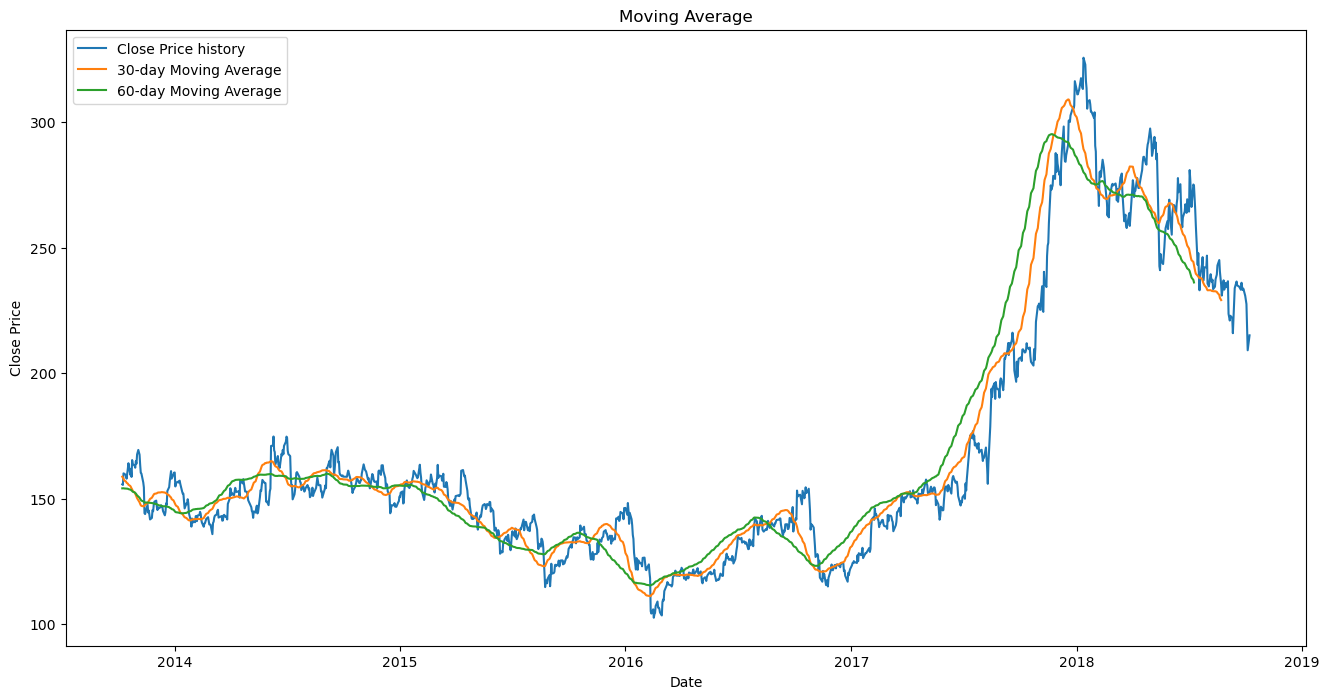

In [2]:
# Load the dataset
df = pd.read_csv('NSE-TATAGLOBAL11.csv')

# Data preprocessing
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')

# Moving Average
def moving_average(data, window_size):
    return data['Close'].rolling(window=window_size).mean()

# Plotting the Moving Average
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price history')
plt.plot(moving_average(df, 30), label='30-day Moving Average')
plt.plot(moving_average(df, 60), label='60-day Moving Average')
plt.legend(loc='best')
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


Linear Regression RMSE: 70.55987938371486


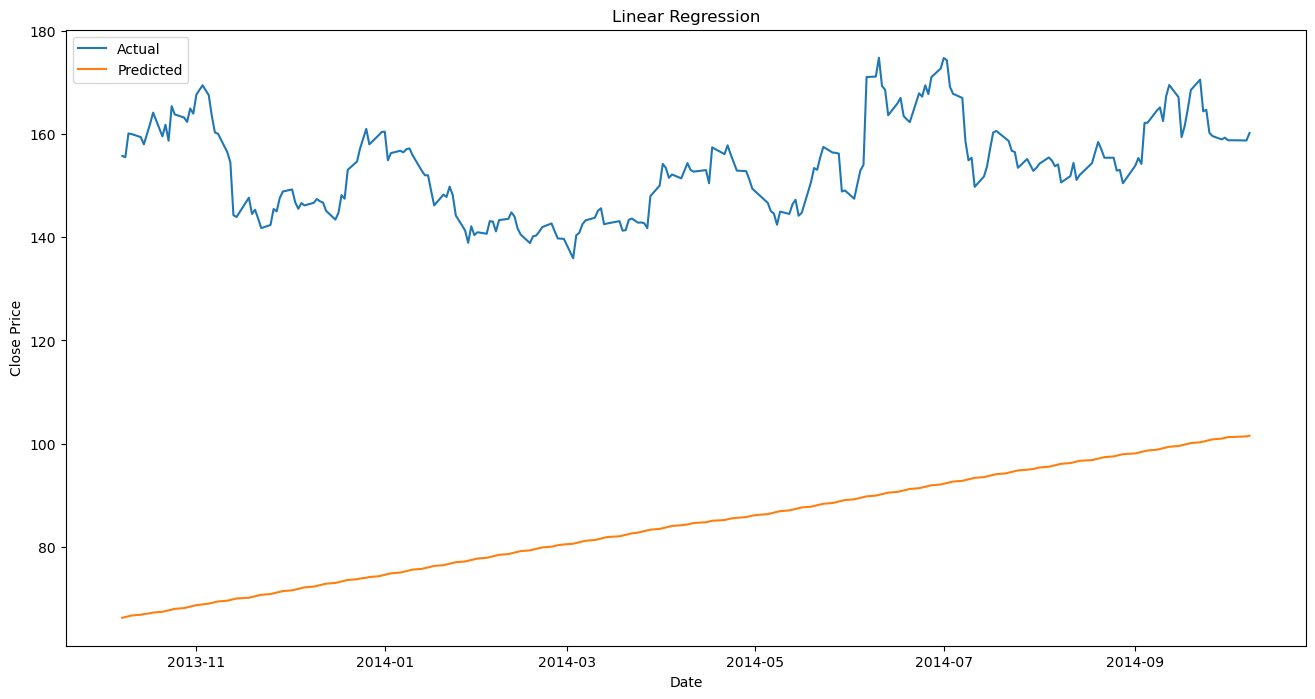

In [3]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

train_size = int(len(df) * 0.8)
train = df[:train_size]
valid = df[train_size:]

x_train = np.arange(len(train)).reshape(-1, 1)
y_train = train['Close']
x_valid = np.arange(len(train), len(df)).reshape(-1, 1)
y_valid = valid['Close']

model = LinearRegression()
model.fit(x_train, y_train)
predictions_lr = model.predict(x_valid)

rmse_lr = np.sqrt(mean_squared_error(y_valid, predictions_lr))
print("Linear Regression RMSE:", rmse_lr)

# Plotting Linear Regression
plt.figure(figsize=(16, 8))
plt.plot(df.index[train_size:], y_valid, label='Actual')
plt.plot(df.index[train_size:], predictions_lr, label='Predicted')
plt.legend(loc='best')
plt.title('Linear Regression')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
Results
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print("LSTM RMSE:", rms)

In [ ]:
# Auto ARIMA
from pmdarima import auto_arima

model_arima = auto_arima(df['Close'][:train_size], trace=True, error_action='ignore', suppress_warnings=True)
model_arima.fit(df['Close'][:train_size])

forecast_arima = model_arima.predict(n_periods=len(valid))
forecast_arima = pd.DataFrame(forecast_arima, index=valid.index, columns=['Prediction'])

rmse_arima = np.sqrt(mean_squared_error(valid['Close'], forecast_arima['Prediction']))
print("Auto ARIMA RMSE:", rmse_arima)

# Plotting Auto ARIMA
plt.figure(figsize=(16, 8))
plt.plot(df.index[train_size:], valid['Close'], label='Actual')
plt.plot(df.index[train_size:], forecast_arima['Prediction'], label='Predicted')
plt.legend(loc='best')
plt.title('Auto ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


In [ ]:
# k-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor

k = 5
model_knn = KNeighborsRegressor(n_neighbors=k)
model_knn.fit(x_train, y_train)

predictions_knn = model_knn.predict(x_valid)

rmse_knn = np.sqrt(mean_squared_error(df['Close'][train_size+60:], predictions_knn))
print("k-Nearest Neighbors RMSE:", rmse_knn)

# Plotting k-Nearest Neighbors
plt.figure(figsize=(16, 8))
plt.plot(df.index[train_size+60:], df['Close'][train_size+60:], label='Actual')
plt.plot(df.index[train_size+60:], predictions_knn, label='Predicted')
plt.legend(loc='best')
plt.title('k-Nearest Neighbors')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Prophet
from fbprophet import Prophet

df_prophet = df.reset_index()
df_prophet = df_prophet[['Date', 'Close']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

model_prophet = Prophet()
model_prophet.fit(df_prophet[:train_size])

future = model_prophet.make_future_dataframe(periods=len(valid))
forecast_prophet = model_prophet.predict(future)

predictions_prophet = forecast_prophet['yhat'][train_size:].values

rmse_prophet = np.sqrt(mean_squared_error(valid['Close'], predictions_prophet))
print("Prophet RMSE:", rmse_prophet)

# Plotting Prophet
plt.figure(figsize=(16, 8))
plt.plot(df.index[train_size:], valid['Close'], label='Actual')
plt.plot(df.index[train_size:], predictions_prophet, label='Predicted')
plt.legend(loc='best')
plt.title('Prophet')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()



